# Example pymaingo ANN global solution and training

From melon doc (https://git.rwth-aachen.de/avt-svt/public/MeLOn/-/blob/master/feedforward%20neural%20network/training/keras/example_training_of_ANN.py) and the ANN paper (https://link.springer.com/content/pdf/10.1007/s10957-018-1396-0.pdf).

## Problem statement:
min $f(x)$

where $f$ is a feed forward neural network. 

The peaks function will be used as a dummy problem and will be approximated by $f$. The peaks function is defined as:

$$ g_{peaks}(x_1, x_2) = 3\cdot(1-x_1)^2 \cdot \exp[-x_1^2-(x_2+1)^2] -10\cdot (x_1/5-x_1^3-x_2^5)\cdot\exp(-x_1^2-x_2^2)- \exp[-(x_1+1)^2-x_2^2]/3$$

$$g_{peaks} : \mathbb{R}^2 \to \mathbb{R}$$

The function dominion is defined as $D = \{x_1, x_2 \in \mathbb{R}: -3 \leq x_1,x_2 \leq 3 \}$

The initial dataset will be generated by Latin hypercube sampling.

In [1]:
import utils
import tensorflow as tf
import numpy as np
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pyDOE import lhs
import maingopy

Implement peaks function as defined above

In [2]:
def peaks(X):
    term1 = 3*np.multiply((1-X[:,0])**2, np.exp(-(X[:,0])**2-(X[:,1]+1)**2))
    term2 = np.multiply(-10*(X[:,0]/5-X[:,0]**3-X[:,1]**5), np.exp(-X[:,0]**2-X[:,1]**2))
    term3 = -np.exp(-(X[:,0]+1)**2-X[:,1]**2)/3
    y = term1 + term2 + term3
    return np.expand_dims(y, axis=-1)

In [3]:
# test global minimum at f(0.228, -1.626)=-6.551
peaks(np.array([[0.228, -1.626], [0.5,0.5]]))

array([[-6.55112995],
       [ 0.37537558]])

## Training data generation

Generate 600 samples with latin hypercube sampling (LHS) (package pyDOE), rescale to [-3, 3] and evaluate.

In [4]:
lhd = lhs(2, samples=600)
Xpeaks = lhd*6-3
ypeaks = peaks(Xpeaks)

## Set parameters

In [5]:
problem_name = 'peaks'
# dimensionality of the data
input_dim = 2
output_dim = 1
# scale Input to [-1,1] range
scaleInput = True
# normalize Output to z-score
normalizeOutput = True

define scale and normalize (from melon keras utils)

In [6]:
def scale(X, scaleInput):
    # scale Input values to range [-1,1] in each dimension
    if (scaleInput):
        nom = (X -  X.min(axis=0))*2
        denom = X.max(axis=0) - X.min(axis=0)
        denom[denom==0] = 1
        return -1 + nom/denom
    else:
        return X

def normalize(y, normalizeOutput):
    # normalize output to z-score
    if(normalizeOutput):
        y_norm = (y - np.mean(y, axis=0))/np.std(y, axis=0);
        return y_norm
    else:
        return y

In [7]:
Xnorm = scale(Xpeaks, scaleInput)
ynorm = normalize(ypeaks, normalizeOutput)

In [8]:
# split into test, validation and test sets (70-15-15% split)
Xtrain, Xval, ytrain, yval = train_test_split(Xnorm, ynorm, test_size=0.15)
n_train = Xtrain.shape[0]

## Set output parameters

Two hidden layers of 10, 8 (different from source paper)-> (2x10+1) + (10x8+1) + (8x1)+1 = 127 parameters to optimize.

ReLU activation function for the all activation functions exctept the output layer, which is linear. 

Learning by first-order stochastic gradient descent (ADAM, https://arxiv.org/abs/1412.6980) for 100 epochs with a 0.001 leraning rate (default).

In [9]:
# output filename
output_folder = "./data/Output/"
filename_out = output_folder + problem_name
# training parameters
network_layout = [10, 8]
activation_function = 'relu'
activation_function_out = 'linear'
learning_rate = 0.001
kernel_regularizer = tf.keras.regularizers.l2(l=0.0001)  # L2 regularization penalty
# 'he_normal' for relu activation, 'glorot_uniform' for everything else
kernel_initializer = 'he_normal'
# It draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / fan_in) where fan_in is the number of input units in the weight tensor.
optimizer = 'adam'
epochs = 1000
#batch_size = 128
random_state = 1

## Build model

With the inputs defined above:

keras.sequential: a plain stack of layers where each layer has exactly one input tensor and one output tensor.


In [10]:
# Sequential class: Linear stack of layers.
model = tf.keras.Sequential()
# Create and add first layer
model.add(tf.keras.layers.Dense(network_layout[0],
                                name="input",
                                kernel_initializer=kernel_initializer,
                                kernel_regularizer=kernel_regularizer,
                                activation=activation_function,
                                input_dim=input_dim))
# Create and add all remaining layers (in this case, 9x9 layout)
for neuron in network_layout[1:]:
    model.add(tf.keras.layers.Dense(neuron,
                                    kernel_initializer=kernel_initializer,
                                    kernel_regularizer=kernel_regularizer,
                                    activation=activation_function))
# Output layer w linear function
model.add(tf.keras.layers.Dense(output_dim, name="output",
                                kernel_initializer='glorot_uniform',
                                kernel_regularizer=kernel_regularizer,
                                activation=activation_function_out))

model.compile(loss='mse', optimizer=optimizer, metrics=['mse', 'mae'])
# Generate a table summarizing the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 10)                30        
                                                                 
 dense (Dense)               (None, 8)                 88        
                                                                 
 output (Dense)              (None, 1)                 9         
                                                                 
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________


## Train ANN model on dataset

First-order gradient-based optimization of stochastic objective functions (https://arxiv.org/abs/1412.6980)

In [11]:
############################  TRAINING ############################ 

training_time = time.time()

history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval),
                    epochs=epochs, verbose=1)

# history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval),
#                     epochs=epochs, batch_size=batch_size, verbose=1)
training_time = training_time - time.time()

Epoch 1/1000
16/16 [==============================] - 1s 10ms/step - loss: 0.9538 - mse: 0.9504 - mae: 0.6804 - val_loss: 1.1203 - val_mse: 1.1168 - val_mae: 0.7712
Epoch 2/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.8645 - mse: 0.8611 - mae: 0.6364 - val_loss: 1.0464 - val_mse: 1.0430 - val_mae: 0.7323
Epoch 3/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.8210 - mse: 0.8176 - mae: 0.6216 - val_loss: 1.0123 - val_mse: 1.0089 - val_mae: 0.7237
Epoch 4/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.7975 - mse: 0.7941 - mae: 0.6176 - val_loss: 0.9907 - val_mse: 0.9873 - val_mae: 0.7187
Epoch 5/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.7801 - mse: 0.7767 - mae: 0.6134 - val_loss: 0.9719 - val_mse: 0.9686 - val_mae: 0.7110
Epoch 6/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.7651 - mse: 0.7617 - mae: 0.6062 - val_loss: 0.9610 - val_mse: 0.9576 - val_mae: 0.7048
Epoch 7/1000
16

Epoch 51/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.4952 - mse: 0.4914 - mae: 0.4837 - val_loss: 0.6779 - val_mse: 0.6740 - val_mae: 0.5843
Epoch 52/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.4924 - mse: 0.4886 - mae: 0.4836 - val_loss: 0.6769 - val_mse: 0.6731 - val_mae: 0.5837
Epoch 53/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.4902 - mse: 0.4863 - mae: 0.4837 - val_loss: 0.6723 - val_mse: 0.6684 - val_mae: 0.5827
Epoch 54/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.4933 - mse: 0.4894 - mae: 0.4857 - val_loss: 0.6725 - val_mse: 0.6686 - val_mae: 0.5808
Epoch 55/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.4851 - mse: 0.4812 - mae: 0.4805 - val_loss: 0.6620 - val_mse: 0.6580 - val_mae: 0.5764
Epoch 56/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.4828 - mse: 0.4789 - mae: 0.4783 - val_loss: 0.6667 - val_mse: 0.6627 - val_mae: 0.5786
Epoch 57/1

Epoch 101/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.3900 - mse: 0.3852 - mae: 0.4379 - val_loss: 0.5455 - val_mse: 0.5408 - val_mae: 0.5170
Epoch 102/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.3881 - mse: 0.3834 - mae: 0.4359 - val_loss: 0.5430 - val_mse: 0.5383 - val_mae: 0.5147
Epoch 103/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.3901 - mse: 0.3854 - mae: 0.4385 - val_loss: 0.5389 - val_mse: 0.5341 - val_mae: 0.5128
Epoch 104/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.3884 - mse: 0.3836 - mae: 0.4339 - val_loss: 0.5367 - val_mse: 0.5319 - val_mae: 0.5126
Epoch 105/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.3843 - mse: 0.3795 - mae: 0.4360 - val_loss: 0.5399 - val_mse: 0.5351 - val_mae: 0.5152
Epoch 106/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.3824 - mse: 0.3776 - mae: 0.4328 - val_loss: 0.5338 - val_mse: 0.5290 - val_mae: 0.5118
Epoc

16/16 [==============================] - 0s 2ms/step - loss: 0.3370 - mse: 0.3316 - mae: 0.4122 - val_loss: 0.4681 - val_mse: 0.4626 - val_mae: 0.4699
Epoch 151/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.3332 - mse: 0.3277 - mae: 0.4028 - val_loss: 0.4699 - val_mse: 0.4644 - val_mae: 0.4717
Epoch 152/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.3339 - mse: 0.3285 - mae: 0.4083 - val_loss: 0.4720 - val_mse: 0.4665 - val_mae: 0.4747
Epoch 153/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.3313 - mse: 0.3259 - mae: 0.4026 - val_loss: 0.4680 - val_mse: 0.4626 - val_mae: 0.4724
Epoch 154/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.3309 - mse: 0.3254 - mae: 0.4081 - val_loss: 0.4643 - val_mse: 0.4588 - val_mae: 0.4677
Epoch 155/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.3286 - mse: 0.3231 - mae: 0.4004 - val_loss: 0.4653 - val_mse: 0.4597 - val_mae: 0.4672
Epoch 156/1000
16/1

16/16 [==============================] - 0s 2ms/step - loss: 0.2828 - mse: 0.2767 - mae: 0.3771 - val_loss: 0.4023 - val_mse: 0.3962 - val_mae: 0.4348
Epoch 200/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.2824 - mse: 0.2763 - mae: 0.3757 - val_loss: 0.4017 - val_mse: 0.3956 - val_mae: 0.4346
Epoch 201/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.2826 - mse: 0.2765 - mae: 0.3774 - val_loss: 0.3989 - val_mse: 0.3928 - val_mae: 0.4305
Epoch 202/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.2822 - mse: 0.2761 - mae: 0.3751 - val_loss: 0.4049 - val_mse: 0.3988 - val_mae: 0.4410
Epoch 203/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.2793 - mse: 0.2731 - mae: 0.3753 - val_loss: 0.3979 - val_mse: 0.3918 - val_mae: 0.4265
Epoch 204/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.2785 - mse: 0.2723 - mae: 0.3701 - val_loss: 0.3983 - val_mse: 0.3922 - val_mae: 0.4337
Epoch 205/1000
16/1

16/16 [==============================] - 0s 2ms/step - loss: 0.2362 - mse: 0.2295 - mae: 0.3328 - val_loss: 0.3497 - val_mse: 0.3429 - val_mae: 0.3956
Epoch 249/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.2329 - mse: 0.2261 - mae: 0.3334 - val_loss: 0.3434 - val_mse: 0.3367 - val_mae: 0.3848
Epoch 250/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.2328 - mse: 0.2260 - mae: 0.3307 - val_loss: 0.3477 - val_mse: 0.3410 - val_mae: 0.3958
Epoch 251/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.2320 - mse: 0.2252 - mae: 0.3338 - val_loss: 0.3410 - val_mse: 0.3342 - val_mae: 0.3815
Epoch 252/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.2320 - mse: 0.2252 - mae: 0.3313 - val_loss: 0.3439 - val_mse: 0.3371 - val_mae: 0.3892
Epoch 253/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.2284 - mse: 0.2216 - mae: 0.3278 - val_loss: 0.3385 - val_mse: 0.3316 - val_mae: 0.3823
Epoch 254/1000
16/1

16/16 [==============================] - 0s 2ms/step - loss: 0.1923 - mse: 0.1849 - mae: 0.2985 - val_loss: 0.3017 - val_mse: 0.2943 - val_mae: 0.3717
Epoch 298/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1918 - mse: 0.1844 - mae: 0.3002 - val_loss: 0.2982 - val_mse: 0.2908 - val_mae: 0.3530
Epoch 299/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1904 - mse: 0.1830 - mae: 0.2961 - val_loss: 0.3049 - val_mse: 0.2974 - val_mae: 0.3749
Epoch 300/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1921 - mse: 0.1846 - mae: 0.2992 - val_loss: 0.2978 - val_mse: 0.2903 - val_mae: 0.3590
Epoch 301/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1888 - mse: 0.1813 - mae: 0.2974 - val_loss: 0.2968 - val_mse: 0.2893 - val_mae: 0.3576
Epoch 302/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1899 - mse: 0.1824 - mae: 0.2964 - val_loss: 0.2999 - val_mse: 0.2924 - val_mae: 0.3579
Epoch 303/1000
16/1

16/16 [==============================] - 0s 2ms/step - loss: 0.1560 - mse: 0.1479 - mae: 0.2682 - val_loss: 0.2507 - val_mse: 0.2426 - val_mae: 0.3281
Epoch 347/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1564 - mse: 0.1483 - mae: 0.2684 - val_loss: 0.2522 - val_mse: 0.2441 - val_mae: 0.3318
Epoch 348/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1552 - mse: 0.1471 - mae: 0.2665 - val_loss: 0.2569 - val_mse: 0.2488 - val_mae: 0.3448
Epoch 349/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1552 - mse: 0.1470 - mae: 0.2680 - val_loss: 0.2483 - val_mse: 0.2401 - val_mae: 0.3351
Epoch 350/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1541 - mse: 0.1459 - mae: 0.2659 - val_loss: 0.2573 - val_mse: 0.2492 - val_mae: 0.3431
Epoch 351/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1555 - mse: 0.1473 - mae: 0.2697 - val_loss: 0.2473 - val_mse: 0.2391 - val_mae: 0.3254
Epoch 352/1000
16/1

16/16 [==============================] - 0s 2ms/step - loss: 0.1258 - mse: 0.1170 - mae: 0.2359 - val_loss: 0.2028 - val_mse: 0.1940 - val_mae: 0.2986
Epoch 396/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1241 - mse: 0.1154 - mae: 0.2341 - val_loss: 0.1998 - val_mse: 0.1910 - val_mae: 0.2952
Epoch 397/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1231 - mse: 0.1143 - mae: 0.2333 - val_loss: 0.2010 - val_mse: 0.1922 - val_mae: 0.2946
Epoch 398/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1223 - mse: 0.1135 - mae: 0.2334 - val_loss: 0.1997 - val_mse: 0.1908 - val_mae: 0.2977
Epoch 399/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1223 - mse: 0.1135 - mae: 0.2328 - val_loss: 0.1988 - val_mse: 0.1900 - val_mae: 0.2987
Epoch 400/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1210 - mse: 0.1122 - mae: 0.2322 - val_loss: 0.1992 - val_mse: 0.1903 - val_mae: 0.2997
Epoch 401/1000
16/1

16/16 [==============================] - 0s 2ms/step - loss: 0.1042 - mse: 0.0949 - mae: 0.2189 - val_loss: 0.1640 - val_mse: 0.1547 - val_mae: 0.2752
Epoch 445/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1037 - mse: 0.0944 - mae: 0.2169 - val_loss: 0.1627 - val_mse: 0.1533 - val_mae: 0.2674
Epoch 446/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1033 - mse: 0.0940 - mae: 0.2145 - val_loss: 0.1648 - val_mse: 0.1555 - val_mae: 0.2761
Epoch 447/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1030 - mse: 0.0937 - mae: 0.2159 - val_loss: 0.1659 - val_mse: 0.1566 - val_mae: 0.2825
Epoch 448/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1024 - mse: 0.0930 - mae: 0.2171 - val_loss: 0.1604 - val_mse: 0.1511 - val_mae: 0.2750
Epoch 449/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1029 - mse: 0.0935 - mae: 0.2161 - val_loss: 0.1620 - val_mse: 0.1527 - val_mae: 0.2708
Epoch 450/1000
16/1

16/16 [==============================] - 0s 2ms/step - loss: 0.0917 - mse: 0.0820 - mae: 0.2034 - val_loss: 0.1429 - val_mse: 0.1331 - val_mae: 0.2656
Epoch 494/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0919 - mse: 0.0822 - mae: 0.2063 - val_loss: 0.1318 - val_mse: 0.1221 - val_mae: 0.2474
Epoch 495/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0907 - mse: 0.0809 - mae: 0.2053 - val_loss: 0.1390 - val_mse: 0.1292 - val_mae: 0.2570
Epoch 496/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0917 - mse: 0.0819 - mae: 0.2065 - val_loss: 0.1377 - val_mse: 0.1280 - val_mae: 0.2592
Epoch 497/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0906 - mse: 0.0808 - mae: 0.2037 - val_loss: 0.1323 - val_mse: 0.1225 - val_mae: 0.2504
Epoch 498/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0904 - mse: 0.0807 - mae: 0.2042 - val_loss: 0.1324 - val_mse: 0.1227 - val_mae: 0.2502
Epoch 499/1000
16/1

16/16 [==============================] - 0s 2ms/step - loss: 0.0816 - mse: 0.0716 - mae: 0.1956 - val_loss: 0.1225 - val_mse: 0.1124 - val_mae: 0.2434
Epoch 543/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0831 - mse: 0.0731 - mae: 0.1984 - val_loss: 0.1207 - val_mse: 0.1107 - val_mae: 0.2432
Epoch 544/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0847 - mse: 0.0746 - mae: 0.2032 - val_loss: 0.1225 - val_mse: 0.1124 - val_mae: 0.2421
Epoch 545/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0813 - mse: 0.0712 - mae: 0.1944 - val_loss: 0.1144 - val_mse: 0.1044 - val_mae: 0.2305
Epoch 546/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0833 - mse: 0.0732 - mae: 0.1976 - val_loss: 0.1221 - val_mse: 0.1120 - val_mae: 0.2462
Epoch 547/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0812 - mse: 0.0711 - mae: 0.1960 - val_loss: 0.1266 - val_mse: 0.1165 - val_mae: 0.2531
Epoch 548/1000
16/1

16/16 [==============================] - 0s 2ms/step - loss: 0.0758 - mse: 0.0655 - mae: 0.1892 - val_loss: 0.0997 - val_mse: 0.0894 - val_mae: 0.2151
Epoch 592/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0758 - mse: 0.0655 - mae: 0.1908 - val_loss: 0.1066 - val_mse: 0.0963 - val_mae: 0.2259
Epoch 593/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0766 - mse: 0.0663 - mae: 0.1910 - val_loss: 0.1092 - val_mse: 0.0989 - val_mae: 0.2327
Epoch 594/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0759 - mse: 0.0656 - mae: 0.1897 - val_loss: 0.1108 - val_mse: 0.1005 - val_mae: 0.2357
Epoch 595/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0762 - mse: 0.0658 - mae: 0.1917 - val_loss: 0.1018 - val_mse: 0.0915 - val_mae: 0.2159
Epoch 596/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0768 - mse: 0.0665 - mae: 0.1917 - val_loss: 0.1018 - val_mse: 0.0914 - val_mae: 0.2160
Epoch 597/1000
16/1

16/16 [==============================] - 0s 2ms/step - loss: 0.0714 - mse: 0.0609 - mae: 0.1861 - val_loss: 0.0917 - val_mse: 0.0812 - val_mae: 0.2036
Epoch 641/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0702 - mse: 0.0597 - mae: 0.1827 - val_loss: 0.0942 - val_mse: 0.0837 - val_mae: 0.2098
Epoch 642/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0711 - mse: 0.0606 - mae: 0.1842 - val_loss: 0.0948 - val_mse: 0.0843 - val_mae: 0.2069
Epoch 643/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0706 - mse: 0.0601 - mae: 0.1833 - val_loss: 0.0916 - val_mse: 0.0811 - val_mae: 0.2029
Epoch 644/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0707 - mse: 0.0602 - mae: 0.1839 - val_loss: 0.0928 - val_mse: 0.0823 - val_mae: 0.2042
Epoch 645/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0696 - mse: 0.0591 - mae: 0.1826 - val_loss: 0.1042 - val_mse: 0.0937 - val_mae: 0.2285
Epoch 646/1000
16/1

16/16 [==============================] - 0s 2ms/step - loss: 0.0677 - mse: 0.0571 - mae: 0.1797 - val_loss: 0.0902 - val_mse: 0.0796 - val_mae: 0.2062
Epoch 690/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0688 - mse: 0.0581 - mae: 0.1831 - val_loss: 0.0881 - val_mse: 0.0774 - val_mae: 0.1999
Epoch 691/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0667 - mse: 0.0561 - mae: 0.1794 - val_loss: 0.0847 - val_mse: 0.0741 - val_mae: 0.1944
Epoch 692/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0662 - mse: 0.0556 - mae: 0.1771 - val_loss: 0.0866 - val_mse: 0.0759 - val_mae: 0.1945
Epoch 693/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0660 - mse: 0.0554 - mae: 0.1768 - val_loss: 0.0867 - val_mse: 0.0761 - val_mae: 0.1950
Epoch 694/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0656 - mse: 0.0550 - mae: 0.1760 - val_loss: 0.0931 - val_mse: 0.0824 - val_mae: 0.2105
Epoch 695/1000
16/1

16/16 [==============================] - 0s 2ms/step - loss: 0.0634 - mse: 0.0527 - mae: 0.1745 - val_loss: 0.0845 - val_mse: 0.0737 - val_mae: 0.1925
Epoch 739/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0632 - mse: 0.0525 - mae: 0.1740 - val_loss: 0.0890 - val_mse: 0.0782 - val_mae: 0.2006
Epoch 740/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0638 - mse: 0.0531 - mae: 0.1756 - val_loss: 0.0902 - val_mse: 0.0794 - val_mae: 0.2021
Epoch 741/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0660 - mse: 0.0552 - mae: 0.1809 - val_loss: 0.0849 - val_mse: 0.0742 - val_mae: 0.1942
Epoch 742/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0634 - mse: 0.0526 - mae: 0.1731 - val_loss: 0.0837 - val_mse: 0.0730 - val_mae: 0.1888
Epoch 743/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0651 - mse: 0.0544 - mae: 0.1787 - val_loss: 0.0793 - val_mse: 0.0686 - val_mae: 0.1787
Epoch 744/1000
16/1

16/16 [==============================] - 0s 2ms/step - loss: 0.0601 - mse: 0.0492 - mae: 0.1711 - val_loss: 0.0768 - val_mse: 0.0660 - val_mae: 0.1796
Epoch 788/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0614 - mse: 0.0505 - mae: 0.1723 - val_loss: 0.0846 - val_mse: 0.0737 - val_mae: 0.1931
Epoch 789/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0618 - mse: 0.0510 - mae: 0.1729 - val_loss: 0.0816 - val_mse: 0.0707 - val_mae: 0.1861
Epoch 790/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0624 - mse: 0.0515 - mae: 0.1765 - val_loss: 0.0756 - val_mse: 0.0648 - val_mae: 0.1744
Epoch 791/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0604 - mse: 0.0495 - mae: 0.1703 - val_loss: 0.0782 - val_mse: 0.0673 - val_mae: 0.1803
Epoch 792/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0605 - mse: 0.0497 - mae: 0.1708 - val_loss: 0.0766 - val_mse: 0.0657 - val_mae: 0.1747
Epoch 793/1000
16/1

16/16 [==============================] - 0s 2ms/step - loss: 0.0596 - mse: 0.0487 - mae: 0.1703 - val_loss: 0.0763 - val_mse: 0.0653 - val_mae: 0.1827
Epoch 837/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0590 - mse: 0.0480 - mae: 0.1697 - val_loss: 0.0727 - val_mse: 0.0617 - val_mae: 0.1690
Epoch 838/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0578 - mse: 0.0469 - mae: 0.1658 - val_loss: 0.0816 - val_mse: 0.0707 - val_mae: 0.1882
Epoch 839/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0582 - mse: 0.0472 - mae: 0.1665 - val_loss: 0.0752 - val_mse: 0.0642 - val_mae: 0.1726
Epoch 840/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0586 - mse: 0.0476 - mae: 0.1684 - val_loss: 0.0730 - val_mse: 0.0620 - val_mae: 0.1713
Epoch 841/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0580 - mse: 0.0470 - mae: 0.1669 - val_loss: 0.0762 - val_mse: 0.0652 - val_mae: 0.1785
Epoch 842/1000
16/1

16/16 [==============================] - 0s 2ms/step - loss: 0.0573 - mse: 0.0463 - mae: 0.1666 - val_loss: 0.0774 - val_mse: 0.0664 - val_mae: 0.1829
Epoch 886/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0579 - mse: 0.0469 - mae: 0.1698 - val_loss: 0.0743 - val_mse: 0.0632 - val_mae: 0.1755
Epoch 887/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0574 - mse: 0.0464 - mae: 0.1674 - val_loss: 0.0756 - val_mse: 0.0646 - val_mae: 0.1738
Epoch 888/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0577 - mse: 0.0467 - mae: 0.1673 - val_loss: 0.0737 - val_mse: 0.0627 - val_mae: 0.1747
Epoch 889/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0573 - mse: 0.0463 - mae: 0.1663 - val_loss: 0.0720 - val_mse: 0.0610 - val_mae: 0.1698
Epoch 890/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0582 - mse: 0.0471 - mae: 0.1672 - val_loss: 0.0705 - val_mse: 0.0595 - val_mae: 0.1680
Epoch 891/1000
16/1

16/16 [==============================] - 0s 2ms/step - loss: 0.0567 - mse: 0.0457 - mae: 0.1655 - val_loss: 0.0715 - val_mse: 0.0605 - val_mae: 0.1709
Epoch 935/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0555 - mse: 0.0444 - mae: 0.1635 - val_loss: 0.0687 - val_mse: 0.0576 - val_mae: 0.1619
Epoch 936/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0559 - mse: 0.0448 - mae: 0.1644 - val_loss: 0.0685 - val_mse: 0.0574 - val_mae: 0.1627
Epoch 937/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0579 - mse: 0.0469 - mae: 0.1689 - val_loss: 0.0807 - val_mse: 0.0696 - val_mae: 0.1846
Epoch 938/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0574 - mse: 0.0463 - mae: 0.1690 - val_loss: 0.0711 - val_mse: 0.0600 - val_mae: 0.1743
Epoch 939/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0565 - mse: 0.0454 - mae: 0.1657 - val_loss: 0.0747 - val_mse: 0.0636 - val_mae: 0.1715
Epoch 940/1000
16/1

16/16 [==============================] - 0s 2ms/step - loss: 0.0558 - mse: 0.0447 - mae: 0.1633 - val_loss: 0.0706 - val_mse: 0.0594 - val_mae: 0.1712
Epoch 984/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0558 - mse: 0.0447 - mae: 0.1624 - val_loss: 0.0715 - val_mse: 0.0604 - val_mae: 0.1740
Epoch 985/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0547 - mse: 0.0436 - mae: 0.1606 - val_loss: 0.0716 - val_mse: 0.0605 - val_mae: 0.1689
Epoch 986/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0551 - mse: 0.0440 - mae: 0.1607 - val_loss: 0.0748 - val_mse: 0.0637 - val_mae: 0.1833
Epoch 987/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0568 - mse: 0.0457 - mae: 0.1673 - val_loss: 0.0671 - val_mse: 0.0560 - val_mae: 0.1627
Epoch 988/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0553 - mse: 0.0441 - mae: 0.1619 - val_loss: 0.0688 - val_mse: 0.0577 - val_mae: 0.1627
Epoch 989/1000
16/1

In [12]:
# Save entire model to a HDF5 file
model.save(filename_out + '_model.h5')
# Save model to XML
utils.save_model_to_xml(filename_out + '.xml', model, Xpeaks, ypeaks, scaleInput, normalizeOutput)
# plot predictions
y_pred = model.predict(Xnorm)

## Plot surrogate function

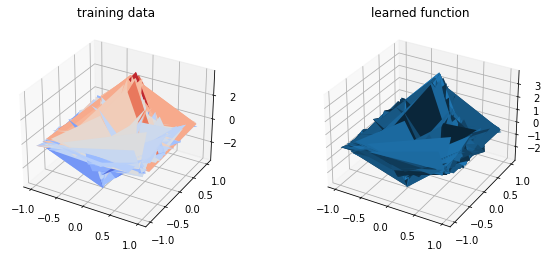

In [13]:
############################ PLOT PREDICTIONS ############################ 
n_train = Xnorm.shape[0]
n_rt = np.sqrt(n_train).astype(int)
X = np.zeros((n_rt, n_rt))
Y = np.zeros((n_rt, n_rt))
Z_true = np.zeros((n_rt, n_rt))
Z_pred = np.zeros((n_rt, n_rt))
for i in range(n_rt):
    for j in range(n_rt):
        X[i, j] = Xnorm[i * n_rt + j, 0]
        Y[i, j] = Xnorm[i * n_rt + j, 1]
        Z_true[i, j] = ynorm[i * n_rt + j]
        Z_pred[i, j] = y_pred[i * n_rt + j]

fig = plt.figure(figsize=plt.figaspect(0.4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
cmap = plt.get_cmap('coolwarm')
ax.plot_surface(X, Y, Z_true, cmap=cmap)
ax.set_title('training data')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X, Y, Z_pred)
ax.set_title('learned function')
plt.show()


## Optimize surrogate model with maingopy

Melon computes the relaxations of the feed forward network ````maingopy.melonpy.FeedForwardNet()```` needed by the B&B solver by providing envelopes of the activation functions (currently supported: purelin, linear, tanh, tansig, relu, relu6). The procedure is the same with gaussian processes and support vector machines.

We load the trained model information from the generated XML file (see utils for details). which will be the optimization problem parameters. Then, we define the problem bounds of $D$ (see problem definition) in maingopy. Lastly, we define the evaluation function for maingopy.

Maingopy then takes the envelopes of the ANN and performs a global deterministic optimization (it is  B&B solver with a reduced space formulation for these envelopes, speeding up computation: https://www.avt.rwth-aachen.de/global/show_document.asp?id=aaaaaaaaabclahw). 

In [14]:
# To define a model, we need to spcecialize the MAiNGOmodel class
class Model(maingopy.MAiNGOmodel):
    def __init__(self):
        maingopy.MAiNGOmodel.__init__(self)
        # Initialize feedforward neural network and load data from example csv file
        self.ffANN = maingopy.melonpy.FeedForwardNet()
        # folder where the model xml is stored
        self.path = "./data/Output/"
        # xml filename
        self.fileName= "peaks"
        # open them (define that it is an XML instead of a CSV)
        self.ffANN.load_model(self.path, self.fileName, maingopy.melonpy.XML)

    # We need to implement the get_variables functions for specifying the optimization varibles
    def get_variables(self):
        # define bounds of the original variables, so that it rescales the results fo the optimization
        # the optimization is done with the normalized version of these values
        variables = [ maingopy.OptimizationVariable(maingopy.Bounds(-3,3), maingopy.VT_CONTINUOUS, "x"),
                      maingopy.OptimizationVariable(maingopy.Bounds(-3,3), maingopy.VT_CONTINUOUS, "y") ]
        return variables

    # We need to implement the evaluate function that computes the values of the objective and constraints from the variables.
    # Note that the variables in the 'vars' argument of this function do correspond to the optimization variables defined in the get_variables function.
    # However, they are different objects for technical reasons. The only mapping we have between them is the position in the list.
    # The results of the evaluation (i.e., objective and constraint values) need to be return in an EvaluationContainer
    def evaluate(self, vars):
        x = vars[0]
        y = vars[1]
        
        # Inputs to the ANN are the variables x and y
        annInputs = [x, y]
        
        # Evaluate the network (in reduced-space)
        # This returns a list, because the output of the network may be multidimensional
        annOutputs = self.ffANN.calculate_prediction_reduced_space(annInputs)

        # Set the ANN output (only 1 in this case) as objective to be minimized
        result = maingopy.EvaluationContainer()
        result.objective = annOutputs[0]

        return result

In [15]:
# To work with the problem, we first create an instance of the model.
myModel = Model()
# We then create an instance of MAiNGO, the solver, and hand it the model.
myMAiNGO = maingopy.MAiNGO(myModel)

In [16]:
# We can have MAiNGO read a settings file:
#fileName = ""
#myMAiNGO.read_settings(fileName) # If fileName is empty, MAiNGO will attempt to open MAiNGOSettings.txt
myMAiNGO.set_log_file_name(".logs/my_log_file.log")
myMAiNGO.set_option("writeCsv", True)
myMAiNGO.set_iterations_csv_file_name(".logs/iterations.csv")
myMAiNGO.set_solution_and_statistics_csv_file_name(".logs/solution_and_statistics.csv")

You can see the input in form of a GAMS file in case you are interested in ````./logs/my_problem_file_MAiNGO.gms````.

In [17]:
myMAiNGO.write_model_to_file_in_other_language(writingLanguage=maingopy.LANG_GAMS, fileName="./logs/my_problem_file_MAiNGO.gms", solverName="SCIP", writeRelaxationOnly=False)

### Solution

In [18]:
# Finally, we call the solve routine to solve the problem.
maingoStatus = myMAiNGO.solve()
print(maingoStatus)

RETCODE.GLOBALLY_OPTIMAL


In [21]:
print("Global optimum of the surrogate model: f([{}, {}]) = {}".format(myMAiNGO.get_solution_point()[0], myMAiNGO.get_solution_point()[1], myMAiNGO.get_objective_value()))

Global optimum of the surrogate model: f([0.01803778752488362, -1.6162844084498615]) = -5.524714314936309


In [22]:
print("ANN value at true minimum = g(0.228, -1.626) = {}".format(myMAiNGO.evaluate_model_at_point(np.array([0.228, -1.626]))))

ANN value at true minimum = g(0.228, -1.626) = ([-4.890676507020417], True)
